In [169]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Distributed estimation of the centroid and the ascending direction -
"""
!python -V || python3 -V

Python 3.12.7


In [170]:
# If executed from Google Colab --------------------------------------------------------
# !git clone https://github.com/jesusBV20/source_seeking_distr.git
# !rsync -a source_seeking_distr/ .
# !rm -r source_seeking_distr

# If you want to use latex with matplotlib ---------------------------------------------
# !apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
# !pip install -y latex

In [171]:
import numpy as np
import os
import csv
import ast
import xml.etree.ElementTree as ET
import re
import sys
from tqdm import tqdm
import pandas as pd

# Graphic tools
from IPython.display import HTML
from matplotlib.animation import PillowWriter, FFMpegWriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --------------------------------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Scalar field functions
from sourceseeking_distr.scalar_field.sigma_funcs import SigmaGauss, SigmaNonconvex, SigmaFract 

# Main utility functions used along the notebook
from sourceseeking_distr.toolbox.math_utils import XY_distrib, gen_random_graph, gen_Z_split
from sourceseeking_distr.toolbox.basic_utils import createDir
from sourceseeking_distr.toolbox.plot_utils import kw_def_patch, kw_def_arrow, unicycle_patch, vector2d
from sourceseeking_distr.toolbox.math_utils import unit_vec, L_sigma



# --------------------------------------------------------------------------------------

# Create the output directory
OUTPUT_FOLDER = os.path.join("..","output")
createDir(OUTPUT_FOLDER)

The directory '../output' already exists!


In [172]:
class SSconSim:
    def __init__(self, k_asc, k_cen, device_n, iter_n):
        self.device_n = device_n
        self.k_asc = k_asc	
        self.k_cen = k_cen
        self.iter_n = iter_n
        self.com_graph = np.array([[0,1,0],
                                   [1,0,1],
                                   [0,1,0]])
  
    def calc_asc_at_step(self, step, centroids, sigmas):
        assert(step <= self.iter_n and len(centroids) == self.device_n and len(sigmas) == self.device_n and step >= 0)
        
        asc_dirs = np.zeros((self.device_n, self.device_n, 2))
        
        for dev in range(self.device_n):
            asc_dirs[dev, dev] = centroids[dev] * sigmas[dev]
        
        for _ in range(step):
            prev_asc_dirs = asc_dirs.copy()
            for s_dev in range(self.device_n):
                for p_dev in range(self.device_n):
                    if (self.com_graph[s_dev, p_dev] == 1):
                        asc_dirs[s_dev, p_dev] = prev_asc_dirs[p_dev, p_dev]
                    else:
                        asc_dirs[s_dev, p_dev] = prev_asc_dirs[s_dev, s_dev]
                
                asc_dir_sum = np.zeros((2))    
                for dev in range(self.device_n):
                    asc_dir_sum += asc_dirs[s_dev, s_dev] - asc_dirs[s_dev,dev]
                    
                asc_dirs[s_dev, s_dev] += -self.k_asc * asc_dir_sum
        
        asc_dirs_ret = np.zeros((self.device_n, 2))
        for s_dev in range(self.device_n):
            asc_dirs_ret[s_dev] = asc_dirs[s_dev, s_dev]
            
        # Normalize asc_dirs_ret to unit vectors
        asc_dirs_ret = asc_dirs_ret / np.linalg.norm(asc_dirs_ret, axis=1, keepdims=True)
        
        return asc_dirs_ret
    
    def calc_cen_at_step(self, step, pos):
        assert(step <= self.iter_n and len(pos) == self.device_n and step >= 0)
        
        centroids = np.zeros((self.device_n, self.device_n, 2))
        
        pos_sum = np.zeros((self.device_n, 2))
        for s_dev in range(self.device_n):
            for p_dev in range(self.device_n):
                pos_sum[s_dev] += pos[s_dev] - pos[p_dev]
        
        for s_dev in range(self.device_n):
            cen_sum = np.zeros((2))    
            for dev in range(self.device_n):
                cen_sum += centroids[s_dev, s_dev] - centroids[s_dev,dev]
            centroids[s_dev, s_dev] += -self.k_cen * (cen_sum - pos_sum[s_dev])
        
        for _ in range(step):
            prev_centroids = centroids.copy()
            for s_dev in range(self.device_n):
                for p_dev in range(self.device_n):
                    if (self.com_graph[s_dev][p_dev] == 1):
                        centroids[s_dev, p_dev] = prev_centroids[p_dev, p_dev]
                    else:
                        centroids[s_dev, p_dev] = prev_centroids[s_dev, s_dev] - (pos[s_dev] - pos[p_dev])
                        
                cen_sum = np.zeros((2))
                for dev in range(self.device_n):
                    cen_sum += centroids[s_dev, s_dev] - centroids[s_dev,dev]
                centroids[s_dev, s_dev] += -self.k_cen * (cen_sum - pos_sum[s_dev])
        
        centroids_ret = np.zeros((self.device_n, 2))
        for s_dev in range(self.device_n):
            centroids_ret[s_dev] = centroids[s_dev, s_dev]
        
        return centroids_ret

## Centroid estimation

In [173]:
from scipy.integrate import odeint
from matplotlib.legend import Legend # legend artist
from matplotlib.animation import FuncAnimation

# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------

def build_B(list_edges, n):
    B = np.zeros((n,len(list_edges)))
    for i in range(len(list_edges)):
        B[list_edges[i][0]-1, i] = 1
        B[list_edges[i][1]-1, i] = -1
    return B

def build_L_from_B(B):
    L = B@B.T
    return L

def dyn_centroid_estimation(xhat_0, t, Lb, x, k=1):
    xhat_dt = - k*(Lb.dot(xhat_0) - Lb.dot(x))
    return xhat_dt

# ----------------------------------------------------------------------
# Main function
# ----------------------------------------------------------------------

def plot_centroid_estimation(ax, P, Z, C, legend=False, xlab=False, ylab=False):
    """
    Funtion that visualises the estimation of the centroid
    """
    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    scale = np.max(np.linalg.norm(P-pc,axis=1))

    # Same shape
    xc_est0 = P
    xc_est = P-C
    # print(xc_est0)
    # print(xc_est)
    # ------------------------------------------------------------------
    
    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])


    # -- Plotting --
    # Axis configuration
    ds = scale + scale/5
    ax.axis([pc[0]-ds, pc[0]+ds, pc[1]-ds, pc[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(1, min_eig_val)
    ax.set_title(title)
    
    if xlab:
       ax.set_xlabel("$X$ [L]")
    if ylab:
        ax.set_ylabel("$Y$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)

    for edge in Z:
        ax.plot([P[edge[0]-1,0], P[edge[1]-1,0]], [P[edge[0]-1,1], P[edge[1]-1,1]], "k--", alpha=0.6)

    # Agents
    ax.scatter(P[:,0], P[:,1], color="k", s=15)
    # phi = np.pi/3
    # for n in range(N):
    #     icon = unicycle_patch(X[n,:], phi, "royalblue", **kw_def_patch(scale))
    #     ax.add_patch(icon)

    # Points
    # ax.scatter(pc[0], pc[1], c="k", marker=r"$x$", s=scale*100, zorder=4)
    ax.scatter(xc_est0[:,0], xc_est0[:,1], c="red", marker=r"$x$", alpha=0.4, s=scale*100)
    ax.scatter(xc_est[:,0], xc_est[:,1]  , c="red", marker=r"$x$", s=scale*100)


    # Generate the legend
    if legend:
        mrk1 = plt.scatter([],[],c='k'  ,marker=r'$x$',s=60)
        mrk2 = plt.scatter([],[],c='red',marker=r'$x$',s=60)

        leg = Legend(ax, [mrk1, mrk2], 
                    [r"$p_c$ (Non-computed)",
                    r"${p_{c}}^i$: Actual computed centroid from $i$"],
                    loc="upper left", prop={'size': 12}, ncol=1)

        ax.add_artist(leg)


def plot_estimation_evolution(P, Z, C):
    """
    Funtion to visualise the estimated centroid over time
    """
    

    N = P.shape[0]

    pc = np.sum(P, axis=0)/N
    pb = P.flatten()

    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)
    
    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])

    xhat = C

    # ------------------------------------------------------------------

    # -- Plotting --
    fig = plt.figure(figsize=(10, 8))
    ax1, ax2 = fig.subplots(2,1)

    # Axis configuration
    ax1.grid(True)
    ax2.grid(True)

    title = r"$k$ = {0:.2f}, $\lambda_2$ = {1:.2f}".format(1, min_eig_val)
    ax1.set_title(title)
    
    ax2.set_xlabel("$t$ [T]")
    ax1.set_ylabel("$x$ [L]")
    ax2.set_ylabel("$y$ [L]")

    # Lines
    ax1.axhline(0, c="k", ls="-", lw=1.1)
    ax1.axvline(0, c="k", ls="-", lw=1.1)
    ax2.axhline(0, c="k", ls="-", lw=1.1)
    ax2.axvline(0, c="k", ls="-", lw=1.1)

    for i in range(P.shape[0]):
        ax1.plot(pb[2*i] - xhat[:,2*i], label=i)
        ax2.plot(pb[2*i+1] - xhat[:,2*i+1])

        ax1.legend()


def anim_centroid_estimation(ss_npa, Z, N, fps=30):
    """
    Funtion to animate the centroid estimation
    """
    
    P = ss_npa["DWSS_DATA:pos"]
    S = ss_npa["DWSS_DATA:sigma"]
    C = ss_npa["DWSS_DATA:centroid"]
    mu = ss_npa["DWSS_DATA:asc_dir_norm"]
    
    p_max = np.array([np.max(P[:,:,0]),np.max(P[:,:,1])])
    p_min = np.array([np.min(P[:,:,0]),np.min(P[:,:,1])])
    
    s_max = np.max(S[:,:])
    s_min = np.min(S[:,:][S>1e-5])

    scale = np.max(np.linalg.norm(p_max-p_min))
    
    # Build the Laplacian matrix
    B = build_B(Z,N)
    L = build_L_from_B(B)

    # Compute algebraic connectivity (lambda_2)
    eig_vals = np.linalg.eigvals(L)
    min_eig_val = np.min(eig_vals[eig_vals > 1e-7])

    # Simulation -------------------------------------------------------
    
    pc_hat = P-C
        
    # S = -1*S[:,:] + 2*s_max
        
    # Precalculated ----------------------------------------------------
    
    pc_comp = np.average(P, axis=1)
    
    pc_sim = np.zeros_like(pc_hat)
    mu_sim = np.zeros_like(mu)
    
    sim = SSconSim(ss_npa["DWSS_DATA:k_asc"][0,0], ss_npa["DWSS_DATA:k_cen"][0,0], N, ss_npa["DWSS_DATA:iter_n"][0,0])
        
    for i, data_point in enumerate(P):
        pc_sim[i] = sim.calc_cen_at_step(ss_npa["DWSS_DATA:step"][i,0], data_point)
        
    pc_sim = P-pc_sim
    
    for i, data_point in enumerate(C):
        mu_sim[i] = sim.calc_asc_at_step(ss_npa["DWSS_DATA:step"][i,0], data_point, ss_npa["DWSS_DATA:sigma"][i])
    
    mu_field = np.array([5,25])
    A = np.eye(2)
    sigma_test = SigmaGauss(mu=mu_field, max_intensity=2000, dev=30)
    sigma_test.A = A
    
    # S_comp = np.apply_along_axis(sigma_test.eval_value, axis=2, arr=P)
    # S_comp = S_comp[:,:,0]
     
    mu_err = np.arccos(np.einsum('ijk,ijk->ij', mu, mu_sim))
    c_err = pc_hat - np.broadcast_to(pc_comp[:, np.newaxis, :], pc_hat.shape)
    c_err = np.linalg.norm(c_err, axis=2)

    # ------------------------------------------------------------------

    # -- Error plot --
    fig_err = plt.figure()
    ax_mu_err, ax_c_err = fig_err.subplots(2,1)

    # Axis configuration
    ax_c_err.grid(True)
    ax_mu_err.grid(True)

    ax_c_err.set_xlabel("$T$")
    ax_c_err.set_ylabel("Centroid error (m)")
    ax_mu_err.set_xlabel("$T$")
    ax_mu_err.set_ylabel("L error(rad)")

    # Lines
    ax_c_err.axhline(0, c="k", ls="-", lw=1.1)
    ax_c_err.axvline(0, c="k", ls="-", lw=1.1)
    ax_mu_err.axhline(0, c="k", ls="-", lw=1.1)
    ax_mu_err.axhline(np.pi/2, c="k", ls="-", lw=1.1)
    ax_mu_err.axvline(0, c="k", ls="-", lw=1.1)

    for i in range(P.shape[1]):
        ax_c_err.plot(c_err[:,i], label=i)
        ax_mu_err.plot(mu_err[:,i], label=i)

        ax_c_err.legend()

    # -- Animation --
    fig = plt.figure()
    ax = fig.subplots()
    
    # Axis configuration
    ds = scale/4
    ax.axis([p_min[0]-ds, p_max[0]+ds, p_min[1]-ds, p_max[1]+ds])
    ax.set_aspect("equal")
    ax.grid(True)

    title = "SS"
    ax.set_title(title)

    ax.set_xlabel("$Y$ [L]")
    ax.set_ylabel("$X$ [L]")

    # Lines
    ax.axhline(0, c="k", ls="-", lw=1.1)
    ax.axvline(0, c="k", ls="-", lw=1.1)
    
    # sigma_test.draw(fig=fig, ax=ax, xlim=70, ylim=40, n=300, contour_levels=20)

    # Centroids
    pts = ax.scatter(pc_hat[0,:,0], pc_hat[0,:,1], color="r", marker=r"$x$", s=50)
    pts_sim = ax.scatter(pc_sim[0,:,0], pc_sim[0,:,1], color="y", marker=r"$x$", s=50)
    pts_comp = ax.scatter(pc_comp[0,0], pc_comp[0,1], color="b", marker=r"$x$", s=50)

    # Set up the normalization and colormap
    color_norm = mcolors.Normalize(vmin=s_min, vmax=s_max)
    cmap = plt.cm.get_cmap('RdYlGn_r')  # 'RdYlGn_r' is green to red
    
    # Agents
    agts = ax.scatter(P[0,:,0], P[0,:,1], c=S[0,:], s=100, cmap=cmap, norm=color_norm)
            
    # Estimated ascending direction mu
    quivers = ax.quiver(P[0,:,0], P[0,:,1], mu[0,:,0], mu[0,:,1], angles='xy', color="r", scale_units='xy', scale=1/ds)
    
    # Ascending direction computed from centroid data
    quivers_comp = ax.quiver(P[0,:,0], P[0,:,1], mu_sim[0,:,0], mu_sim[0,:,1], color="b", angles='xy', scale_units='xy', scale=1/ds)
    
    agt_edges = []    
    for edge in Z:
        agt_edge, = ax.plot([P[0,edge[0]-1,0], P[0,edge[1]-1,0]], [P[0,edge[0]-1,1], P[0,edge[1]-1,1]], "k--")
        agt_edges.append(agt_edge)

    # -- Building the animation --
    anim_frames = C.shape[0]
    ann_list = []

    # Function to update the animation
    def animate(i):
        for ann in ann_list:
            ann.remove()
        ann_list.clear()
        # Update the centroid estimation markers
        pts.set_offsets(pc_hat[i])
        pts_sim.set_offsets(pc_sim[i])
        pts_comp.set_offsets(pc_comp[i])
        agts.set_offsets(P[i])
        agts.set_array(S[i,:])
        for agt_edge, edge in zip(agt_edges, Z):
            agt_edge.set_data([P[i,edge[0]-1,0], P[i,edge[1]-1,0]], [P[i,edge[0]-1,1], P[i,edge[1]-1,1]])
        
        quivers.set_offsets(P[i])
        quivers.set_UVC(mu[i,:,0], mu[i,:,1])
        
        quivers_comp.set_offsets(P[i])
        quivers_comp.set_UVC(mu_sim[i,:,0], mu_sim[i,:,1])
        
        # Step number
        for j, (x, y) in enumerate(P[i,:,:]):
            ann_list.append(ax.annotate(f"{j}:{ss_npa["DWSS_DATA:step"][i,j]}", (x, y), 
                        textcoords="offset points", xytext=(0,10), ha='center'))

    # Generate the animation
    print("Simulating {0:d} frames...".format(anim_frames))
    anim = FuncAnimation(fig, animate, frames=tqdm(range(anim_frames), initial=1, position=0), 
                         interval=1/fps*1000)
    anim.embed_limit = 40

    # Close plots and return the animation class to be compiled
    plt.close()
    return anim

 98%|█████████▊| 81/83 [03:54<00:05,  2.93s/it]


## Data input

In [174]:
class SSReader:
    CSV_FIELDS = ("DWSS_DATA:step", "DWSS_DATA:last_pos", "DWSS_DATA:centroid", "DWSS_DATA:last_centroid", 
              "DWSS_DATA:asc_dir", "DWSS_DATA:asc_dir_norm", "DWSS_DATA:pos", "DWSS_DATA:sigma", "DWSS_DATA:iter_n", 
              "DWSS_DATA:k_cen", "DWSS_DATA:k_asc", "DWSS_DATA:field_offset")

    def __init__(self, dirpath: str):
        self.dirpath = dirpath
        self.data_dict = {}
        self.min_len = 9999999
        self.load_all_csv_in_folder()

    def parse_value(self, value):
        """
        Parse a string value as either a tuple of numbers or a single float.
        Returns default values in case of parsing errors.
        """
        try:
            # Check if the value contains a comma, indicating a point in space
            if ',' in value:
                # Attempt to parse as a tuple
                parsed_value = np.array(ast.literal_eval(f'({value})'))
                return parsed_value
            elif '.' in value:
                # Attempt to parse as a float
                return float(value)
            else:
                return int(value)
        except (ValueError, SyntaxError, TypeError):
            # Return default values in case of errors
            if ',' in value:
                return np.array([0.0, 0.0])  # Default for tuple values
            else:
                return 0.0  # Default for single float values

    def load_csv_to_dict(self, filename):
        """Load a CSV file into a dictionary with lists of parsed values."""
        data_dict = {}
        
        # Open the CSV file with tab delimiter
        with open(filename, mode='r') as csvfile:
            csvreader = csv.DictReader(csvfile, delimiter='\t')
            
            # Fill the dictionary with parsed data
            for row in csvreader:
                for header in csvreader.fieldnames:
                    if header in self.CSV_FIELDS:
                        if header not in data_dict:
                            data_dict[header] = []
                        data_dict[header].append(self.parse_value(row[header]))
        
        return data_dict

    def convert_dict_to_numpy_arrays(self, data_dict):
        """Convert lists in the dictionary to appropriate NumPy arrays or keep them as lists if necessary."""
        numpy_arrays = {}
        for key, value in data_dict.items():
            # Check if the list contains only scalars
            if all(isinstance(v, (float, int)) for v in value):
                numpy_arrays[key] = np.array(value)
            else:
                numpy_arrays[key] = np.vstack(value)
                
            if len(numpy_arrays[key]) < self.min_len:
                self.min_len = len(numpy_arrays[key])
        
        return numpy_arrays

    def load_all_csv_in_folder(self):
        # List all CSV files in the given folder
        for file_name in os.listdir(self.dirpath):
            if file_name.endswith('.csv'):
                # Get the full file path
                file_path = os.path.join(self.dirpath, file_name)
                
                # Load CSV data into a dictionary
                data_dict = self.load_csv_to_dict(file_path)
                
                # Convert the dictionary to appropriate NumPy arrays or lists
                numpy_arrays = self.convert_dict_to_numpy_arrays(data_dict)
                
                # Store the result in the self.data_dict dictionary, using the file name (without extension) as the key
                
                file_date, file_id = self.extract_date_and_id_from_filename(file_name)
                    
                if file_date not in self.data_dict:
                    self.data_dict[file_date] = {}
                
                if file_id not in self.data_dict[file_date]:
                    self.data_dict[file_date][file_id] = {}
                    
                self.data_dict[file_date][file_id] = numpy_arrays
                
    def extract_date_and_id_from_filename(self, filename):
        """Extract the date and ID from the filename in the format [date]_[time]_[id].csv."""
        match = re.match(r"(\d{2}_\d{2}_\d{2}__\d{2}_\d{2}_\d{2})_(\d+)", filename)
        if match:
            date = match.group(1)
            file_id = match.group(2)
            return date, file_id
        return None, None

    def to_npa(self):
        npa_dict = {}
        for file_date, devices in self.data_dict.items():
            new_dict = {}
            for field_name in devices['1'].keys():
                if field_name in self.CSV_FIELDS:
                    # list_t = [dev[field_name][:self.min_len] for dev in devices.values()]
                    # print(list_t)
                    new_dict[field_name] = np.stack([dev[field_name][:self.min_len] for dev in devices.values()], axis=1)
        
        npa_dict[file_date] = new_dict    
        return npa_dict     
          
                        

In [175]:
ss_data =  SSReader("../input_data/")
ss_npa = ss_data.to_npa()

### Some examples

0 :  [1 1]
1 :  [1 2]
2 :  [2 1]


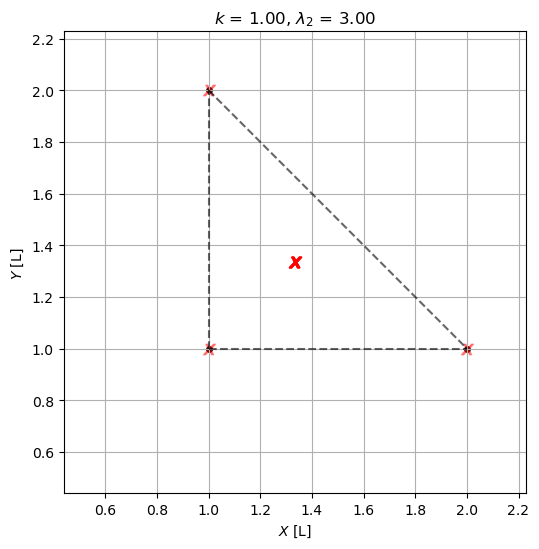

In [176]:
## Parameters #####

p = np.array([[1,1], [1,2], [2,1]])
c = np.array([[-1/3,-1/3], [-1/3,2/3], [2/3,-1/3]])
Z = ((1,2), (2,3), (1,3))


# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(10, 6), dpi=100)
ax  = fig.subplots()

for i in range(p.shape[0]):
    print(i,": ", p[i,:])
plot_centroid_estimation(ax, p, Z, c, legend=False, xlab=True, ylab=True)

# plot_estimation_evolution(p, Z, c)

# Show the plot!
plt.show()

/tmp/ipykernel_251490/457037529.py:270: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')  # 'RdYlGn_r' is green to red


Simulating 83 frames...


100%|██████████| 83/83 [00:07<00:00, 16.07it/s]

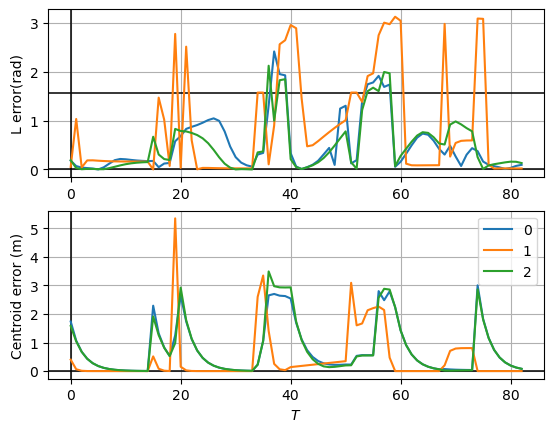

100%|██████████| 83/83 [00:20<00:00, 16.07it/s]

In [177]:

Z = ((1,2), (2,3))

# anim1 = anim_centroid_estimation(p, Z, c, l, s)
# HTML(anim1.to_html5_video())

anim2 = anim_centroid_estimation(ss_npa['24_09_13__12_09_10'], Z, 3, fps=2)
# writer = FFMpegWriter(fps=5)
# anim2.save("animation.mp4", writer=writer)
HTML(anim2.to_html5_video())

# writer = PillowWriter(fps=15, bitrate=1800)
# anim.save(os.path.join(OUTPUT_FOLDER, "centroid1.gif"),
#         writer = writer)